<a href="https://colab.research.google.com/github/lenayak/application_programming_l5/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


    Необходимо загрузить исходный набор данных и соответствующие метки классов.
    Произвести разделение загруженного набора данных на обучающую, тестовую и валидационую выборки (в соотношении 80:10:10). Проверить, что сформированные выборки сбалансированы.
    Написать модель нейронной сети для решения задачи классификации.
    Описать пайплайн предобработки данных. ВАЖНО: что так как ваш вариант предполагает работу с текстом, то необходимо выполниить векторизацию данных (подробности в туториале).
    Написать train loop (цикл обучения). Провести эксперименты по обучению с различными значениями параметров learning rate (скорость обучения) и batch size (размер мини-пакета). Выбрать по 3 значения для learning rate и batch size (итоговое количество экспериментов будет 9).
    Для каждого проведенного эксперимента вывести графики для значения функции потерь (ось x - итерация обучения/номер эпохи; ось y - значение функции потерь) и выбранной метрики качества (ось x - итерация обучения/номер эпохи; ось y - значение метрики качества). Графики необходимо выводить как для обучающей, так и для валидационной выборки.
    Оценить качество работы модели на тестовой выборке.
    Сделайте выводы по полученным результатам проведенных экспериментов. Какую модель из всех полученных стоит использовать?
    Сохранить обученную модель.
    Выполните повторную инициализацию модели и загрузку весов. Продемонстрируйте работоспособность модели (пропустите через нее какой-то отзыв/рецензию и выведите результат).



In [2]:
import pandas as pd
from numpy import loadtxt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import os
from tqdm import trange

from pymystem3 import Mystem

import nltk
from nltk.tokenize import word_tokenize
from nltk import PorterStemmer
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

import random


In [10]:
nltk.download("punkt")
nltk.download("stopwords")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Необходимо загрузить исходный набор данных и соответствующие метки классов.
from google.colab import files
files.upload()


In [6]:
# Описать пайплайн предобработки данных. ВАЖНО: что так как ваш вариант предполагает работу с текстом, то необходимо выполниить векторизацию данных (подробности в туториале).
data = pd.read_csv("dataframe.csv")
data.dropna(inplace=True)
remove_non_alphabets = lambda x: re.sub(r'[^а-яА-Я]',' ',str(x))
tokenize = lambda x: word_tokenize(x, language = "russian")


def Lemmatize(src: list):
    '''Lemmatizes the passed dataset'''
    text_nomalized = ' '.join(src).lower() 
    m = Mystem()
    lemmas = m.lemmatize(text_nomalized)
    return lemmas


print("remove_non_alphabets")
data['review'] = data["review"].apply(remove_non_alphabets)
print("tokenize")
data["review"] = data["review"].apply(tokenize)
print("lemmatize")
for i in data.index:
    data["review"][i] = Lemmatize(data["review"][i])
print("complete")
data["review"] = data["review"].apply(lambda x: ' '.join(x))
data.dropna(inplace=True)
print(data)


remove_non_alphabets
tokenize
lemmatize


Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz
<ipython-input-6-5566d0aae6a2>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["review"][i] = Lemmatize(data['review'][i])


complete
      mark                                             review
0      1.0  однажды   вечер   вечер   вечеромпересматриват...
1      1.0  на   фон   уносить   ветер   который   я   чит...
2      1.0  ну   по   сравнение   с   этот   книга   тот  ...
3      1.0  уже   очень   давно   следить   за   потуга   ...
4      1.0  тропа   у   он   одинаковый   летний   ребенок...
...    ...                                                ...
4995   5.0  какой   удивительный   работа   проделывать   ...
4996   5.0  в   очередной   раз   мочь   написать   сво   ...
4997   5.0  смешной   история   о   то   как   два   жена ...
4998   5.0  небольшой   занимательный   рассказ   этакий  ...
4999   5.0  как   жаль   что   с   скляренко   не   успева...

[4998 rows x 2 columns]


In [8]:
# Произвести разделение загруженного набора данных на обучающую, тестовую и валидационую выборки (в соотношении 80:10:10). Проверить, что сформированные выборки сбалансированы.
frac_seed = random.randint(0,10)
train_df = data.sample(frac=0.9, random_state=frac_seed, ignore_index=True)
valid_df = data.sample(frac=0.1, random_state=frac_seed, ignore_index=True)
for item in valid_df["review"]:
    while item in train_df['review']: 
        tmp = data.sample()
        item["review"] = tmp['review']
        item["mark"] = tmp["mark"]
    
print(data.shape)
print(train_df.shape)
print(valid_df.shape)


(4998, 2)
(4498, 2)
(500, 2)


In [13]:
class LogisticRegression(nn.Module):
    def __init__(self):
        super(LogisticRegression, self).__init__()
        self.linear1 = nn.Linear(10000, 100)
        self.linear2 = nn.Linear(100, 10)
        self.linear3 = nn.Linear(10, 6)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x


x_train = Variable(torch.from_numpy(x_train)).float()
y_train = Variable(torch.from_numpy(y_train)).long()


<ipython-input-15-4e83d5acc77b>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["review"][i] = [el for el in data["review"][i] if el != " "]


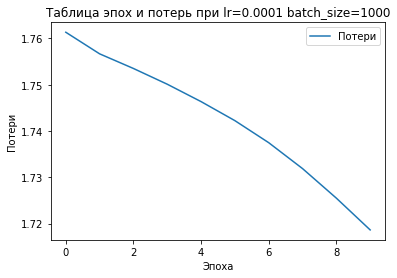

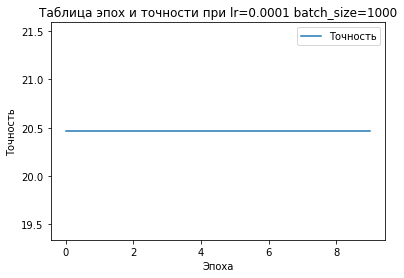

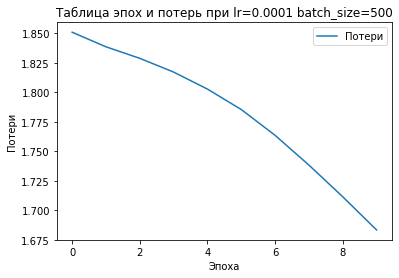

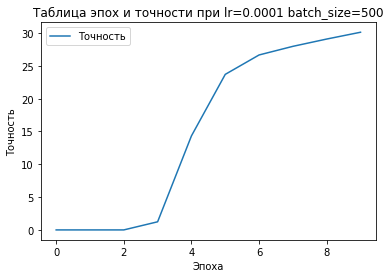

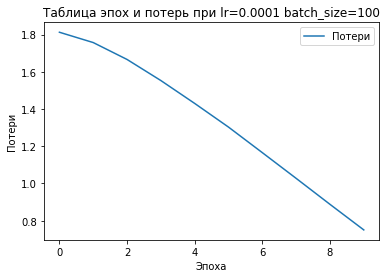

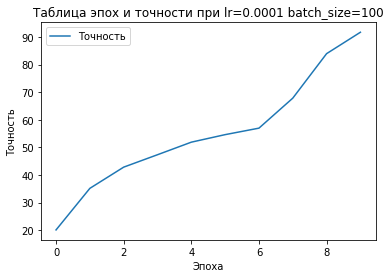

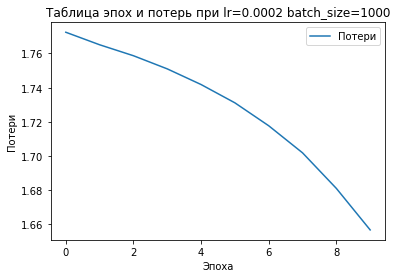

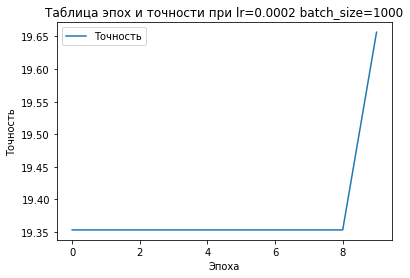

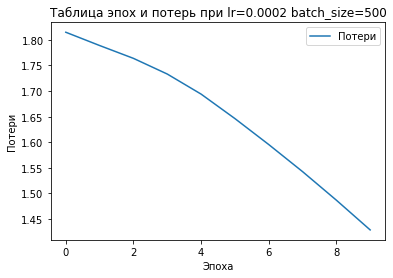

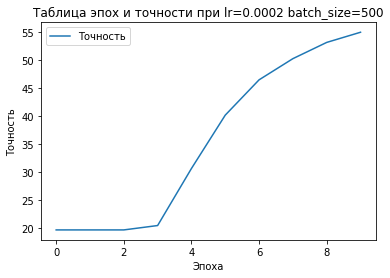

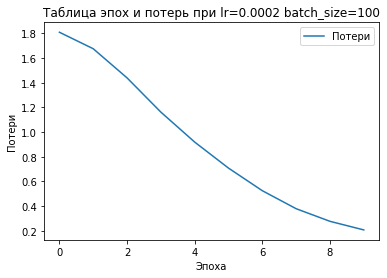

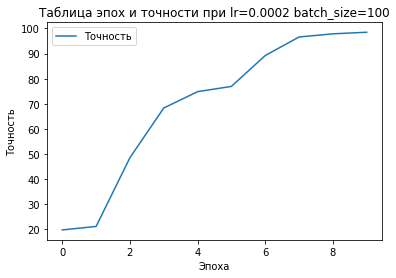

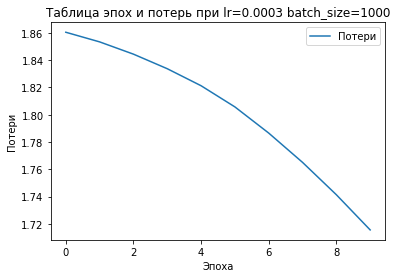

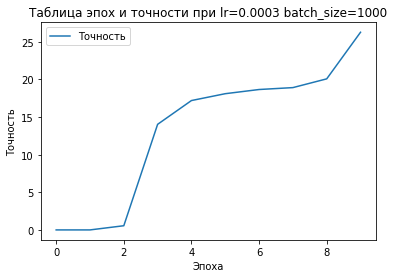

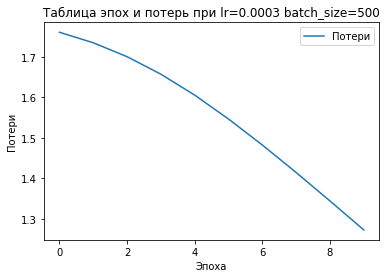

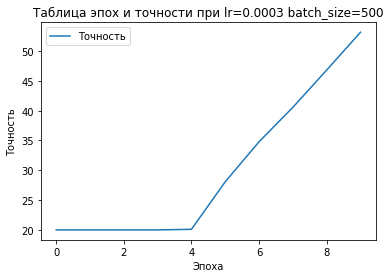

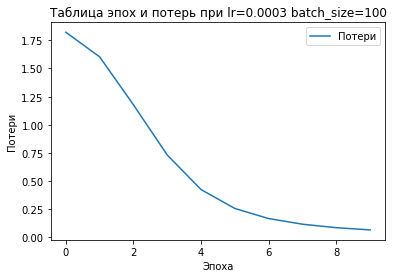

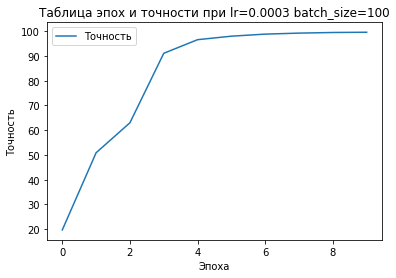

In [15]:
# Для каждого проведенного эксперимента вывести графики для значения функции потерь (ось x - итерация обучения/номер эпохи; ось y - значение функции потерь) и выбранной метрики качества (ось x - итерация обучения/номер эпохи; ось y - значение метрики качества). Графики необходимо выводить как для обучающей, так и для валидационной выборки.
def experiment(lr, batch_size):
    model = LogisticRegression()
    criterion = nn.CrossEntropyLoss()
    data = torch.utils.data.DataLoader(x_train, batch_size = batch_size)
    optimizer = torch.optim.Adam(params=model.parameters(), lr = lr)
    epochs = 10
    model.train()
    loss_values = []
    acc_values = list()
    for epoch in range(epochs):
        for el in data:
            optimizer.zero_grad()
            y_pred = model(x_train)
            loss = criterion(y_pred, y_train)
            loss_values.append(loss.item())
            pred = torch.max(y_pred, 1)[1].eq(y_train).sum()
            acc = pred * 100.0 / len(x_train)
            acc_values.append(acc)
            loss.backward()
            optimizer.step()
    epochs_values = list()
    for i in range(0,epochs): epochs_values.append(i)
    loss_values_graph = list()
    for i in range(0,len(loss_values), len(loss_values)//epochs):
        loss_values_graph.append(loss_values[i])
    acc_values_graph = list()
    for i in range(0,len(acc_values), len(acc_values)//epochs):
        acc_values_graph.append(acc_values[i])
    plt.plot(epochs_values, loss_values_graph)
    plt.title('Таблица эпох и потерь при lr='+str(lr) +" batch_size="+str(batch_size))
    plt.xlabel('Эпоха',)
    plt.ylabel('Потери')
    plt.legend(['Потери'])
    plt.show()
    plt.plot(epochs_values, acc_values_graph)
    plt.title('Таблица эпох и точности при lr='+str(lr) +" batch_size="+str(batch_size))
    plt.xlabel('Эпоха',)
    plt.ylabel('Точность')
    plt.legend(['Точность'])
    plt.show()
    return model


if True:
    for i in data.index:
        data["review"][i] = [el for el in data["review"][i] if el != " "]
    data.to_csv("lemmatized.csv")
    models = list()
    lr_list = [0.0001, 0.0002, 0.0003]
    batch_size = [1000, 500, 100]
    for lr in lr_list:
        for bs in batch_size:
            models.append(experiment(lr, bs))
            

In [16]:
# Оценить качество работы модели на тестовой выборке.
for model in models:
    criterion = nn.CrossEntropyLoss()
    x_test = torch.Tensor(x_test).float()
    y_test = [int(i) for i in y_test]
    y_test = torch.Tensor(y_test).long()
    model.eval()
    with torch.no_grad():
        for i in range(20):
            y_pred = model(x_test)
            loss = criterion(y_pred, y_test)
            pred = torch.max(y_pred, 1)[1].eq(y_test).sum()
        print("Accuracy: {}%".format(100*pred/len(x_test)))
        

Accuracy: 16.481481552124023%
Accuracy: 21.296297073364258%
Accuracy: 28.33333396911621%
Accuracy: 21.296297073364258%
Accuracy: 31.11111068725586%
Accuracy: 31.11111068725586%
Accuracy: 20.185184478759766%
Accuracy: 26.851852416992188%
Accuracy: 30.925926208496094%
